In [1]:
#Importamos librerias
import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sns
pd.options.display.max_rows = 30
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

In [2]:
#Importamos la base de datos
properati = pd.read_csv("properati.csv")

In [3]:
#Como todas las filas en "operation" son ventas, 
#la columna no añade informacion, por lo que se remueve
properati = properati.drop(columns="operation")

In [4]:
#Por ahora nos deshacemos de las columnas "country_name","geonames_id","lat-lon","lat","lon","place_with_parent_names","place_name","properati_url","image_thumbnail"
properati = properati.drop(columns=["floor","expenses","country_name","geonames_id","lat-lon","lat","lon","place_with_parent_names","place_name","properati_url","image_thumbnail"])

In [5]:
#Se le colocan estandares a las variables para lidiar con datos extremos
properati = properati[properati.price_usd_per_m2 < 8000]

properati = properati[properati.price_usd_per_m2 > 500]

properati = properati[properati.surface_covered_in_m2 < 600]

properati = properati[properati.surface_covered_in_m2 > 30]

properati = properati[properati.surface_total_in_m2 > 30]

properati = properati[properati.surface_total_in_m2 < 1000]

properati.shape

(53056, 14)

In [6]:
def cuenta_numeros(string,existe_amb):
    
    #Asigna numeros basados en texto encontrados en un string
    #existe_amb se refiere al sitio donde se encontro una variante de la cadena de caracteres "ambientes"
    #Directamente relacionada con la funcion cuenta_ambientes
    
    if string[existe_amb - 3:existe_amb + 1] == " un ":
        return 1
    
    if string[existe_amb - 4:existe_amb + 1] == " dos ":
        return 2
    
    if string[existe_amb - 5:existe_amb + 1] == " tres ":
        return 3
    
    if string[existe_amb - 7:existe_amb + 1] == " cuatro ":
        return 4
    
    if string[existe_amb - 6:existe_amb + 1] == " cinco ":
        return 5
    
    if string[existe_amb - 5:existe_amb + 1] == " seis ":
        return 6
    
    if string[existe_amb - 6:existe_amb + 1] == " siete ":
        return 7
    
    if string[existe_amb - 5:existe_amb + 1] == " ocho ":
        return 8
    
    

In [7]:
def cuenta_ambientes(string):
    #Programa para contar la cantidad de ambientes en title o descripcion, requiere de la funcion cuenta_numeros.
    numero = 0 #Variable dummy, no es posible que un inmueble tenga cero ambientes.
    string = string.lower() #Reducimos todos los caracteres a minuscula.
    
    existe_amb = string.find(" amb ") #Se hace la primera busqueda, en caso de fallar, devuelve -1.
    
    if existe_amb == -1: #Las preguntas son para conocer si no se ha encontrado la palabra anterior.
        existe_amb = string.find(" amb.")
    
    if existe_amb == -1:
        existe_amb = string.find(" ambientes")
    
    if existe_amb == -1:
        existe_amb = string.find(" ambientes.")
        
    if existe_amb == -1:
        existe_amb = string.find(" ambientes,")
        
    if existe_amb == -1:
        existe_amb = string.find(" ambiente ")
    
    if existe_amb == -1:
        existe_amb = string.find(" ambiente.")
        
    if existe_amb == -1:
        existe_amb = string.find(" dormitorios") 
        
    if existe_amb == -1:
        if string.find(" monoambiente") != -1:
            return 1
        
    if existe_amb == -1:
        if string.find(" monoambiente.") != -1:
            return 1
        
    if existe_amb == -1:
        if string.find(" monoambiente,") != -1:
            return 1
    if existe_amb == -1:
        if string.find(" ambiente unico ") != -1:
            return 1
        
    try: 
        numero = int(string[existe_amb - 2: existe_amb])
    except:
        try:
            numero = int(string[existe_amb - 1: existe_amb])
        except:
            try:
                numero = cuenta_numeros(string,existe_amb)
                return numero
            except:
                existe_amb = -1
                pass
            pass
        
    
    if existe_amb != -1 and numero != 0:
        return abs(numero)
    else:
        return np.nan
    
    
##IDEA: Usar un while y una lista para optimizar esta funcion.

In [8]:
prop_title = properati[["title"]]
prop_desc = properati[["description"]]

c = prop_title.applymap(cuenta_ambientes)
d = prop_desc.applymap(cuenta_ambientes)

print(c.dropna().shape)
print(d.dropna().shape)


(14881, 1)
(35500, 1)


In [9]:
#Rellenamos los datos que no se tenian, con los rooms encontrados.

properati["rooms"].fillna(c["title"],inplace=True) 
properati["rooms"].fillna(d["description"],inplace=True)

In [10]:
properati.isnull().sum()

Unnamed: 0                        0
property_type                     0
state_name                        0
price                             0
currency                          0
price_aprox_local_currency        0
price_aprox_usd                   0
surface_total_in_m2               0
surface_covered_in_m2             0
price_usd_per_m2                  0
price_per_m2                      0
rooms                         10836
description                       0
title                             0
dtype: int64

In [11]:
#Utilizamos una lista de los states que no deseamos que se encuentren en el dataframe.
#Seleccionamos todos los demas.

for i in ['Jujuy','Santiago Del Estero','San Juan','Catamarca','Santa Cruz',"La Pampa","Chaco"]:
    properati = properati[properati.state_name != i] #Es decir, los que no sean de allí.
    
properati[["state_name","price"]].groupby("state_name").count().sort_values("price")

,price
state_name,
Tierra Del Fuego,20
Chubut,28
Salta,30
Entre Ríos,44
San Luis,61
Misiones,64
Tucumán,80
Río Negro,87
Neuquén,182


In [12]:
#Dummies de las columnas listas
properati = pd.get_dummies(properati,["prop_type","curr","state"],columns=["property_type","currency","state_name"])


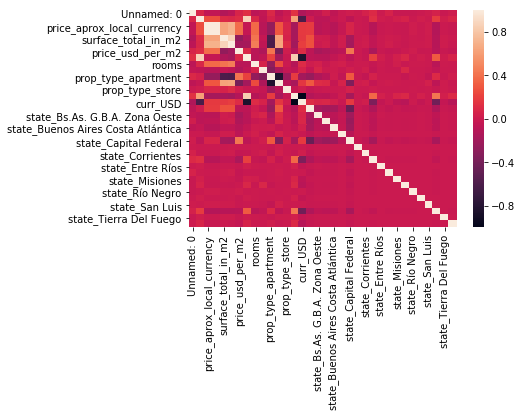

In [13]:
sns.heatmap(properati.corr())

In [14]:
properati.dropna().to_csv("properati_Tasado_Lineal.csv", encoding='utf-8', index=False)